In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader

**Note:** implementing AdamW
How can we do this? Very easily if you’re using the fastai library since its implemented inside. Specifically if you use the fit function, just add the argument use_wd_sched=True:

learn.fit(lr, 1, wds=1e-4, use_wd_sched=True)

- [autoencoder in pytorch](https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1)
- [autoencoder_fastai](https://alanbertl.com/autoencoder-with-fast-ai/)
- [AdamW fastai](https://www.fast.ai/2018/07/02/adam-weight-decay/)

In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

In [3]:
import os
import shutil
import numpy as np

In [4]:
device = torch.cuda.set_device(3) if torch.cuda.is_available() else torch.device('cpu')
device

In [5]:
tfms = ([
    RandTransform(tfm=TfmCrop(crop_pad),
                  kwargs={
                      'row_pct': (0, 1),
                      'col_pct': (0, 1),
                      'padding_mode': 'reflection'
                  },
                  p=1.0,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True),
    RandTransform(tfm=TfmPixel(flip_lr),
                  kwargs={},
                  p=0.5,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True),
    RandTransform(tfm=TfmCoord(symmetric_warp),
                  kwargs={'magnitude': (-0.2, 0.2)},
                  p=0.75,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True),
    RandTransform(tfm=TfmLighting(brightness),
                  kwargs={'change': (0.4, 0.6)},
                  p=0.75,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True),
    RandTransform(tfm=TfmLighting(contrast),
                  kwargs={'scale': (0.8, 1.25)},
                  p=0.75,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True)
], [
    RandTransform(tfm=TfmCrop(crop_pad),
                  kwargs={},
                  p=1.0,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True)
])

### Small image set: CIFAR

In [6]:
! mkdir ../../../../../../SCRATCH2/marvande/data

mkdir: cannot create directory '../../../../../../SCRATCH2/marvande/data': File exists


In [7]:
#path_cifar = untar_data(URLs.CIFAR, dest = '../data')
path_cifar = untar_data(URLs.CIFAR, dest = '../../../../../../SCRATCH2/marvande/data')
path_cifar_train = path_cifar/'train'
path_cifar_test = path_cifar/'test'

In [8]:
print(ImageList.from_folder(path_cifar_train))
print(ImageList.from_folder(path_cifar_test))

ImageList (50000 items)
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: ../../../../../../SCRATCH2/marvande/data/cifar10/train
ImageList (10000 items)
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: ../../../../../../SCRATCH2/marvande/data/cifar10/test


In [9]:
def get_data(path_train, path_test, size, bs):
    src = ImageImageList.from_folder(path_train).split_by_rand_pct(0.2)
    # unsup so no labels, transform to avoid overfitting
    data = src.label_from_func(lambda x: x)\
                .transform(tfms, size=size, tfm_y=True)\
                .add_test(ImageList.from_folder(path_test),tfms=None, tfm_y=False)\
                .databunch(bs=bs).normalize(do_y = True)
    data.c = 3
    return data

In [10]:
size = 32
bs = 32
data_train_cifar = get_data(path_cifar_train, path_cifar_test, size, bs)
data_train_cifar

ImageDataBunch;

Train: LabelList (40000 items)
x: ImageImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: ../../../../../../SCRATCH2/marvande/data/cifar10/train;

Valid: LabelList (10000 items)
x: ImageImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: ../../../../../../SCRATCH2/marvande/data/cifar10/train;

Test: LabelList (10000 items)
x: ImageImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: EmptyLabelList
,,,,
Path: ../../../../../../SCRATCH2/marvande/data/cifar10/train

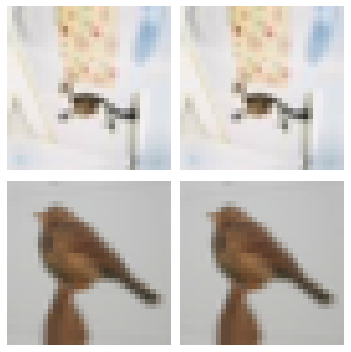

In [11]:
data_train_cifar.show_batch(ds_type=DatasetType.Train, rows=2, figsize=(5,5))

### Bigger image set: PETS

In [12]:
path_pets = untar_data(URLs.PETS, dest = '../../../../../../SCRATCH2/marvande/data')
path_pets_images = path_pets/'images'

In [13]:
! mkdir ../../../../../../SCRATCH2/marvande/data/oxford-iiit-pet/images/train
#! mkdir ../data/oxford-iiit-pet/images/train

mkdir: cannot create directory '../../../../../../SCRATCH2/marvande/data/oxford-iiit-pet/images/train': File exists


In [14]:
! mkdir ../../../../../../SCRATCH2/marvande/data/oxford-iiit-pet/images/test
#! mkdir ../data/oxford-iiit-pet/images/test

mkdir: cannot create directory '../../../../../../SCRATCH2/marvande/data/oxford-iiit-pet/images/test': File exists


In [15]:
! mkdir ../../../../../../SCRATCH2/marvande/data/oxford-iiit-pet/images/test/original
#! mkdir ../data/oxford-iiit-pet/images/test/original

mkdir: cannot create directory '../../../../../../SCRATCH2/marvande/data/oxford-iiit-pet/images/test/original': File exists


In [16]:
! mkdir ../../../../../../SCRATCH2/marvande/data/oxford-iiit-pet/images/train/original
#! mkdir ../data/oxford-iiit-pet/images/train/original

mkdir: cannot create directory '../../../../../../SCRATCH2/marvande/data/oxford-iiit-pet/images/train/original': File exists


Bouge une partie dans le dossier `test`. Le reste doit être bougé dans `train`, mais c'est trop d'images pour le run ici en bash. Donc dans le terminal, faut bouger dans le folder `data/oxford-iiit-pet/images/` et run: `$ mv *.jpg train/original` après avoir run la cell ci-dessous.

In [17]:
"""
source1 = path_pets_images
dest = path_pets_images/'test/original/'
files = os.listdir(source1)
for f in files:
    if np.random.rand(1) < 0.2:
        shutil.move(source1/f, dest/f)
"""

"\nsource1 = path_pets_images\ndest = path_pets_images/'test/original/'\nfiles = os.listdir(source1)\nfor f in files:\n    if np.random.rand(1) < 0.2:\n        shutil.move(source1/f, dest/f)\n"

In [18]:
path_pets_train = path_pets_images/'train/original/'
path_pets_test = path_pets_images/'test/original/'

print(ImageList.from_folder(path_pets_train))
print(ImageList.from_folder(path_pets_test))

ImageList (5918 items)
Image (3, 500, 375),Image (3, 333, 500),Image (3, 224, 300),Image (3, 416, 500),Image (3, 331, 500)
Path: ../../../../../../SCRATCH2/marvande/data/oxford-iiit-pet/images/train/original
ImageList (1472 items)
Image (3, 500, 333),Image (3, 333, 500),Image (3, 500, 333),Image (3, 375, 500),Image (3, 375, 500)
Path: ../../../../../../SCRATCH2/marvande/data/oxford-iiit-pet/images/test/original


Data does not seem to be of the same size... create 256 and 96 sized data:

In [19]:
def resize_one(fn, i, path, size, path_from):
    dest = path/fn.relative_to(path_from)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=100)

Resize train:

In [20]:
path_pets_med_train = path_pets_images/'train/medium_train_256/'
path_pets_small_train = path_pets_images/'train/small_train_96/'

il = ImageList.from_folder(path_pets_train)
# create smaller image sets the first time this nb is run
sets = [(path_pets_small_train, 96), (path_pets_med_train, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size, path_from = path_pets_train), il.items)

Resize test:

In [21]:
path_pets_med_test = path_pets_images/'test/medium_test_256/'
path_pets_small_test = path_pets_images/'test/small_test_96/'

il = ImageList.from_folder(path_pets_test)
# create smaller image sets the first time this nb is run
sets = [(path_pets_small_test, 96), (path_pets_med_test, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size, path_from = path_pets_test), il.items)

In [22]:
size = 128
bs = 5
data_train_pets= get_data(path_pets_med_train, path_pets_med_test, size, bs)
data_train_pets

ImageDataBunch;

Train: LabelList (4735 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: ../../../../../../SCRATCH2/marvande/data/oxford-iiit-pet/images/train/medium_train_256;

Valid: LabelList (1183 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: ../../../../../../SCRATCH2/marvande/data/oxford-iiit-pet/images/train/medium_train_256;

Test: LabelList (1472 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: ../../../../../../SCRATCH2/marvande/data/oxford-iiit-pet/images/train/medium_train_256

Have a look at the data:

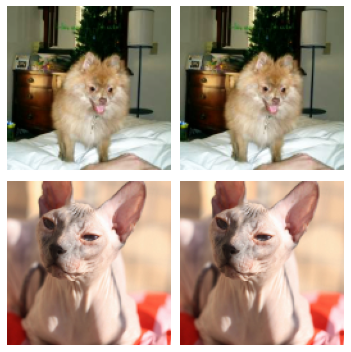

In [23]:
data_train_pets.show_batch(ds_type=DatasetType.Train, rows=2, figsize=(5,5))

### Training:

In [24]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 5, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 8, 4, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 32, 4, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 5, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 5, stride=1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [25]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.convt = nn.ConvTranspose2d(32, 32, 17, stride=1)
        self.relu4 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 3, 1, stride=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn2(x)
        x = self.convt(x)
        x = self.relu4(x)
        x = self.bn3(x)
        x = self.conv5(x)
        x = self.sigmoid(x)
        return x

In [26]:
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=1, padding=2), # 32x32x32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 5, stride=1, padding=2), # 32x32x32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),                           # 32x16x16
            nn.Conv2d(32, 64, 3, stride=1, padding=1), # 64x16x16
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),                           # 64x8x8
            nn.Conv2d(64, 128, 3, stride=1, padding=1), # 128x8x8
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1), # 128x8x8
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=1), # 64x10x10
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=1), # 64x12x12
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=1), # 64x14x14
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=1), # 64x16x16
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 3, 5, stride=1), # 3x20x20
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.ConvTranspose2d(3, 3, 5, stride=1), # 3x24x24
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.ConvTranspose2d(3, 3, 5, stride=1), # 3x28x28
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.ConvTranspose2d(3, 3, 5, stride=1), # 3x32x32
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [27]:
class Model4(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 5, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 4, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 8, 4, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 32, 4, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 4, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 5, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, 5, stride=1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [28]:
class Model5(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, 4, stride=1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [29]:
class Model6(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 2, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 2, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, 4, stride=1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [30]:
class Model7(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 2, stride=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 2, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [31]:
class Model8(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 16, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 16, 3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 3, 4, stride=1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Learn module:
`class Learner
Learner(data:DataBunch, model:Module, opt_func:Callable='Adam', loss_func:Callable=None, metrics:Collection[Callable]=None, true_wd:bool=True, bn_wd:bool=True, wd:Floats=0.01, train_bn:bool=True, path:str=None, model_dir:PathOrStr='models', callback_fns:Collection[Callable]=None, callbacks:Collection[Callback]=<factory>, layer_groups:ModuleList=None, add_time:bool=True, silent:bool=None)`

#### Training on CIFAR:

In [32]:
m1 = Model1().to(device)
m2 = Model2().to(device)
m3 = Model3().to(device)
m4 = Model4().to(device)
m5 = Model5().to(device)
m6 = Model6().to(device)
m7 = Model6().to(device)
m8 = Model8().to(device)



In [33]:
optimizer = optim.Adam
data_set = data_train_cifar

m1:

In [22]:
# Create Learn object:
learn = Learner(data_set,m1,loss_func=F.mse_loss,opt_func=optimizer)
gc.collect();

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


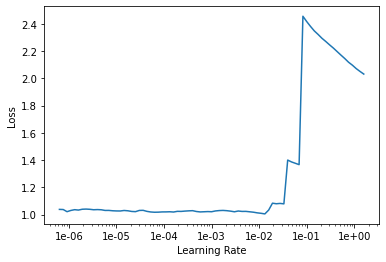

In [23]:
learn.lr_find()
learn.recorder.plot()

In [37]:
# Better to pick LR from learn.find()
lr = 1e-3

In [34]:
def train(model,
          data_set,
          lr,
          loss_func=F.mse_loss,
          opt_func=optim.Adam,
          save_name='model',
          pct_start=0.9):
    # Create Learn object:
    learn = Learner(data_set, model, loss_func=loss_func, opt_func=opt_func)
    gc.collect()
    learn.fit_one_cycle(10, slice(lr), pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

In [28]:
def do_fit(save_name, learn, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,time
0,0.202751,0.234644,00:27
1,0.203945,0.233679,00:27
2,0.198659,0.232044,00:27
3,0.201150,0.232346,00:27
4,0.206003,0.230852,00:27
5,0.200413,0.231913,00:28
6,0.205620,0.230398,00:27
7,0.196327,0.229916,00:27
8,0.203581,0.228849,00:27
9,0.190548,0.221649,00:27


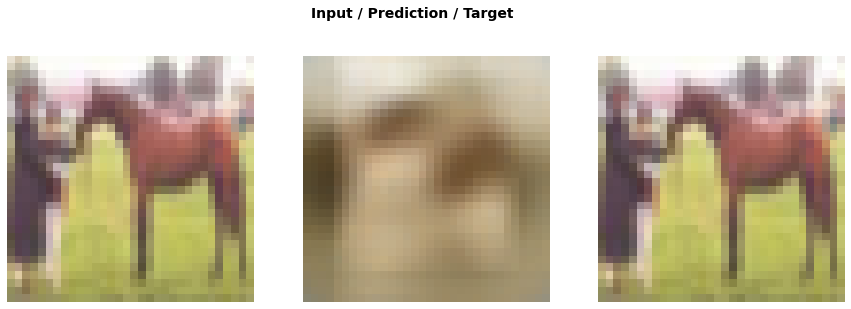

In [36]:
train(m1,
      data_set,
      lr,
      loss_func=F.mse_loss,
      opt_func=optimizer,
      save_name='m1')

m2:

epoch,train_loss,valid_loss,time
0,0.703656,0.703216,00:48
1,0.622435,0.614034,00:47
2,0.565315,0.573473,00:47
3,0.554428,0.558385,00:47
4,0.538947,0.552245,00:47
5,0.542551,0.546396,00:48
6,0.547852,0.544187,00:48
7,0.522970,0.540635,00:48
8,0.531101,0.540911,00:48
9,0.529292,0.535436,00:48


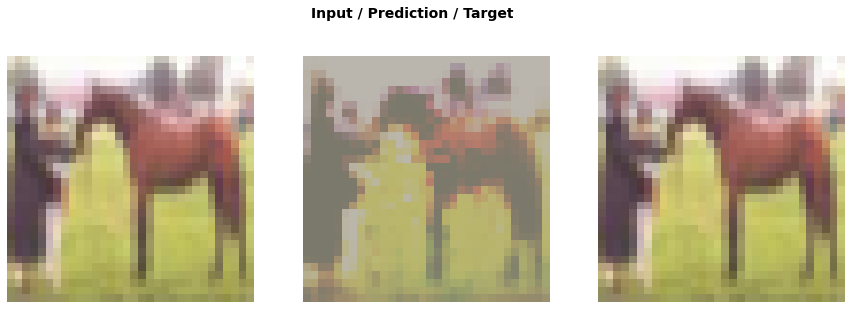

In [38]:
train(m2, data_set, lr, loss_func=F.mse_loss, opt_func=optimizer, save_name = 'm2')

m3:

epoch,train_loss,valid_loss,time
0,0.594661,0.601270,00:44
1,0.589868,0.599814,00:43
2,0.585879,0.598136,00:45
3,0.578078,0.598203,00:44
4,0.565539,0.583152,00:44
5,0.568576,0.576187,00:45
6,0.555918,0.571888,00:45
7,0.566516,0.568522,00:44
8,0.554995,0.568648,00:45
9,0.548106,0.556062,00:46


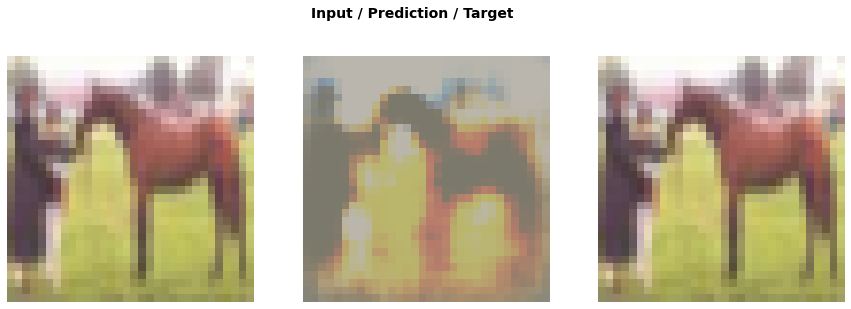

In [64]:
train(m3, data_set, lr, loss_func=F.mse_loss, opt_func=optimizer, save_name = 'm3')

m4:

epoch,train_loss,valid_loss,time
0,0.589312,0.583765,00:35
1,0.410697,0.416685,00:36
2,0.351689,0.351569,00:34
3,0.312311,0.334372,00:34
4,0.291479,0.313445,00:34
5,0.268299,0.270791,00:35
6,0.261522,0.263483,00:34
7,0.256315,0.256266,00:35
8,0.241750,0.251507,00:34
9,0.235575,0.239000,00:34


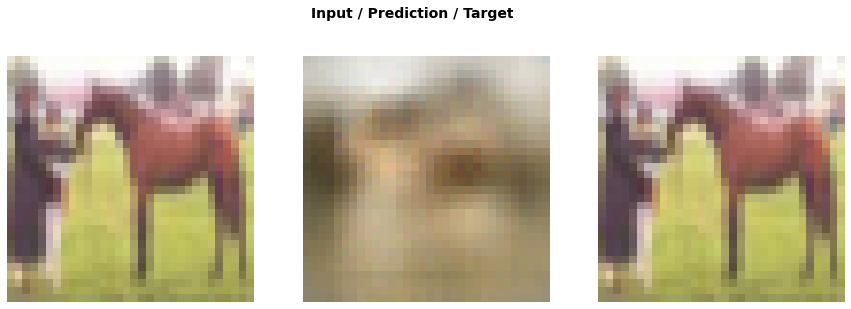

In [65]:
train(m4, data_set, lr, loss_func=F.mse_loss, opt_func=optimizer, save_name = 'm4')

m5:

epoch,train_loss,valid_loss,time
0,0.721442,0.701428,00:46
1,0.452817,0.451722,00:46
2,0.367937,0.361528,00:47
3,0.317339,0.311978,00:47
4,0.277677,0.266657,00:47
5,0.229820,0.224591,00:47
6,0.208049,0.200166,00:47
7,0.192219,0.180856,00:48
8,0.188584,0.178793,00:47
9,0.166221,0.156881,00:48


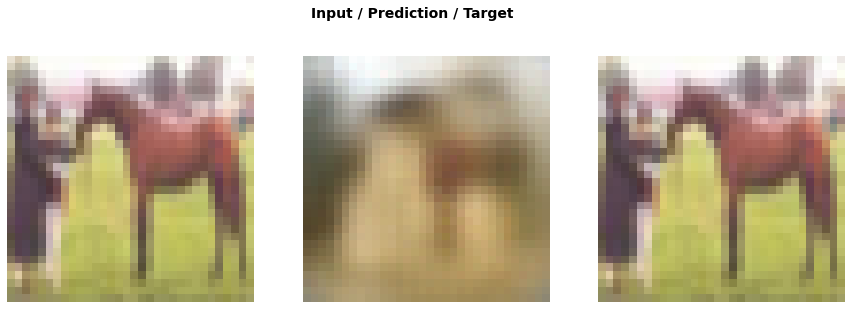

In [66]:
train(m5, data_set, lr, loss_func=F.mse_loss, opt_func=optimizer, save_name = 'm5')

m6:

epoch,train_loss,valid_loss,time
0,0.588232,0.575458,00:47
1,0.381345,0.390360,00:48
2,0.318597,0.315345,00:48
3,0.270442,0.279469,00:48
4,0.213809,0.211832,00:48
5,0.182957,0.179919,00:48
6,0.160758,0.160603,00:48
7,0.151819,0.161900,00:49
8,0.141537,0.134431,00:48
9,0.121180,0.117192,00:48


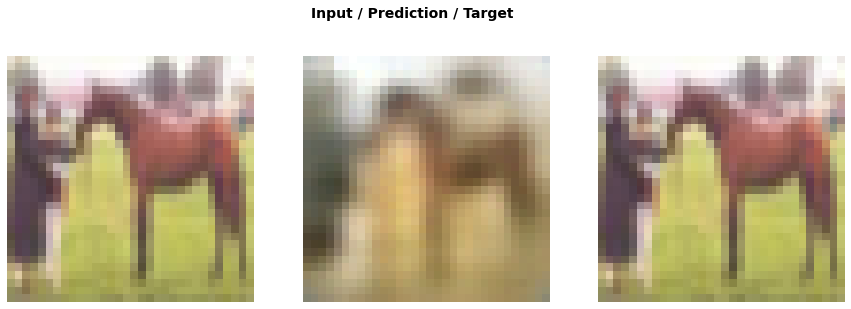

In [67]:
train(m6, data_set, lr, loss_func=F.mse_loss, opt_func=optimizer, save_name = 'm6')

m7:

epoch,train_loss,valid_loss,time
0,0.592597,0.588930,00:49
1,0.383553,0.383337,00:48
2,0.321383,0.324515,00:49
3,0.284063,0.285084,00:49
4,0.233890,0.233943,00:49
5,0.190199,0.187759,00:48
6,0.167861,0.165206,00:48
7,0.154474,0.153797,00:49
8,0.140976,0.138330,00:48
9,0.124524,0.119814,00:48


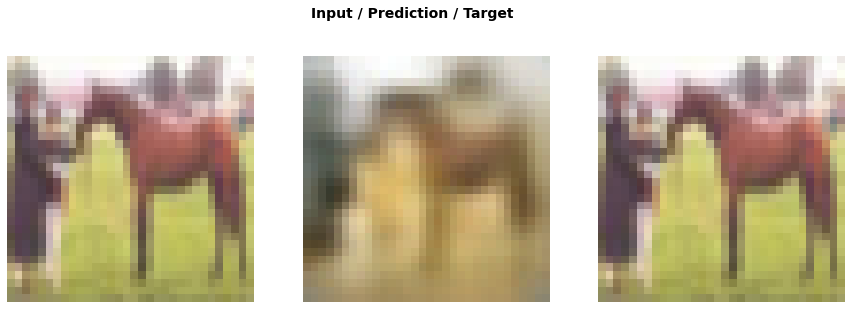

In [68]:
train(m7, data_set, lr, loss_func=F.mse_loss, opt_func=optimizer, save_name = 'm7')

m8:

epoch,train_loss,valid_loss,time
0,1.010760,1.031252,01:10
1,0.665601,0.653325,01:11
2,0.503813,0.496972,01:09
3,0.458468,0.455710,01:11
4,0.444273,0.435393,01:10
5,0.418681,0.421187,01:10
6,0.415013,0.426093,01:11
7,0.396315,0.406950,01:11
8,0.382653,0.386890,01:08
9,0.356693,0.358438,01:09


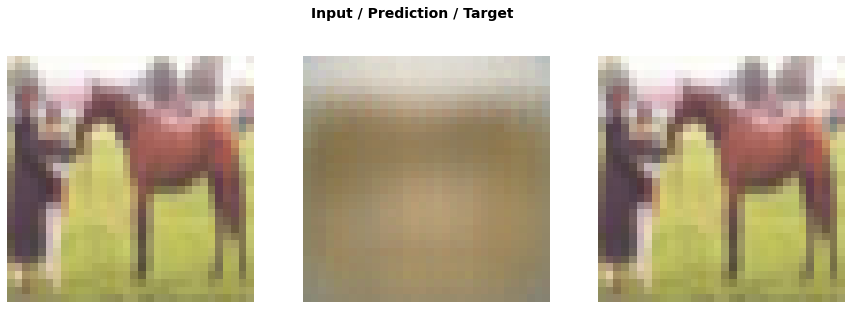

In [69]:
train(m8, data_set, lr, loss_func=F.mse_loss, opt_func=optimizer, save_name = 'm8')

#### Training on PETS:

In [34]:
optimizer = optim.Adam
data_set = data_train_pets

In [35]:
torch.cuda.empty_cache()
gc.collect()
#learn.destroy()

#get free memory (in MBs) for the currently selected gpu id, after emptying the cache
print(
    'free memory (in MBs) for the currently selected gpu id, after emptying the cache: ',
    gpu_mem_get_free_no_cache())

print(
    'used memory (in MBs) for the currently selected gpu id, after emptying the cache:',
    gpu_mem_get_used_no_cache())

gpu_mem_get_all()

free memory (in MBs) for the currently selected gpu id, after emptying the cache:  663
used memory (in MBs) for the currently selected gpu id, after emptying the cache: 11549


[GPUMemory(total=12212, free=12201, used=11),
 GPUMemory(total=12196, free=12185, used=10),
 GPUMemory(total=12196, free=8944, used=3251),
 GPUMemory(total=12212, free=663, used=11549)]

m1:

In [36]:
# Create Learn object:
learn = Learner(data_set,m1,loss_func=F.mse_loss,opt_func=optimizer)
gc.collect();

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


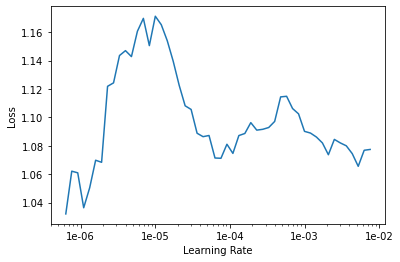

In [37]:
learn.lr_find()
learn.recorder.plot()

In [41]:
# Better to pick LR from learn.find()
lr = 1e-3

In [39]:
def train(model,
          data_set,
          lr,
          loss_func=F.mse_loss,
          opt_func=optim.Adam,
          save_name='model',
          pct_start=0.9):
    # Create Learn object:
    learn = Learner(data_set, model, loss_func=loss_func, opt_func=opt_func)
    gc.collect()
    learn.fit_one_cycle(10, slice(lr), pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

In [42]:
def do_fit(save_name, learn, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,time
0,0.250148,0.254639,00:47
1,0.185027,0.187758,00:47
2,0.152129,0.137431,00:47
3,0.109218,0.105786,00:47
4,0.100673,0.100997,00:48
5,0.080528,0.082648,00:48
6,0.083482,0.082204,00:48
7,0.078213,0.084102,00:47
8,0.068935,0.071149,00:47
9,0.065656,0.064143,00:47


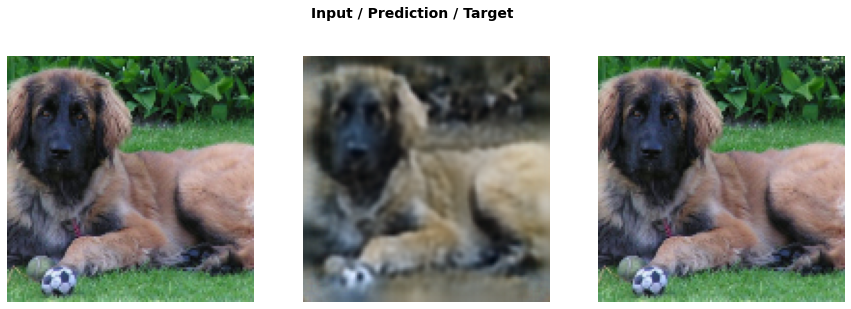

In [43]:
train(m1,
      data_set,
      lr,
      loss_func=F.mse_loss,
      opt_func=optimizer,
      save_name='m1')

m2:

In [46]:
train(m2, data_set, lr, loss_func=F.mse_loss, opt_func=optimizer, save_name = 'm2')

epoch,train_loss,valid_loss,time


RuntimeError: The size of tensor a (80) must match the size of tensor b (128) at non-singleton dimension 3

m3:

In [47]:
train(m3, data_set, lr, loss_func=F.mse_loss, opt_func=optimizer, save_name = 'm3')

epoch,train_loss,valid_loss,time


/home/marvande/image_super_resolution/image_res/lib/python3.7/site-packages/fastai/basic_train.py:30: UserWarning: Using a target size (torch.Size([5, 3, 128, 128])) that is different to the input size (torch.Size([5, 3, 56, 56])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_func(out, *yb)


RuntimeError: The size of tensor a (56) must match the size of tensor b (128) at non-singleton dimension 3

m4:

In [ ]:
train(m4, data_set, lr, loss_func=F.mse_loss, opt_func=optimizer, save_name = 'm4')

m5:

In [ ]:
train(m5, data_set, lr, loss_func=F.mse_loss, opt_func=optimizer, save_name = 'm5')

m6:

In [ ]:
train(m6, data_set, lr, loss_func=F.mse_loss, opt_func=optimizer, save_name = 'm6')

m7:

In [ ]:
train(m7, data_set, lr, loss_func=F.mse_loss, opt_func=optimizer, save_name = 'm7')

m8:

In [ ]:
train(m8, data_set, lr, loss_func=F.mse_loss, opt_func=optimizer, save_name = 'm8')

Brouillon:

In [ ]:
def train_model(model,
                optimizer,
                criterion,
                train_input,
                lr=0.005,
                batch_size=50,
                nb_epoch=8,
                weight_decay=0):
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)

    for e in range(nb_epoch):
        print(e)
        index_train_dl = DataLoader(range(len(train_input)),
                                    batch_size=batch_size,
                                    shuffle=True)
        loss = 0
        for i, batch_indices in enumerate(index_train_dl):
            input_ = train_input[batch_indices]
            output = model(input_)
            
            train_loss = criterion(output, input_)
            
            """
            if i % 10 == 0:
                print(loss)
            """
                
            #reset the gradients back to zero
            optimizer.zero_grad()
            #compute the reconstruction loss on 
            #the training examples, and perform backpropagation of errors
            train_loss.backward()
            #optimize our model
            optimizer.step()
            
            # see how our training is going, 
            # we accumulate the training loss for each epoch 
            loss += train_loss.item()
        
        # compute the epoch training loss
        loss = loss / len(index_train_dl)
        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, nb_epoch, loss))